In [27]:
import os
import pandas
import ggplot
import requests
import matplotlib
%matplotlib inline  
import dateutil.parser
from datetime import datetime
from bs4 import BeautifulSoup
from Pastebin import PastebinAPI

In [2]:
# Brent crude oil data source: http://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=RBRTE&f=D
home_path=os.environ['HOME']
crude_csv_file = os.path.join(home_path,"devel/ipython/data/Europe_Brent_Spot_Price_FOB.csv")

In [3]:
lines_to_skip = 5
names = ['day', 'price']
crude_df = pandas.read_csv(crude_csv_file, names=names, skiprows=lines_to_skip)

# Create a datetime field
crude_df['date'] = crude_df.day.map(lambda x: dateutil.parser.parse(x))

# Normalise price with 100% being the peak price
crude_df['crude_normed_price'] =  crude_df.price / max(crude_df.price)


# Re-order the dataframe with the oldest records first
crude_df = crude_df.sort(ascending=False)
crude_df.head()

/Users/mickeymouse/venvs/default/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(....) is deprecated, use sort_index(.....)


,day,price,date,crude_normed_price
7273,05/20/1987,18.63,1987-05-20,0.129420
7272,05/21/1987,18.45,1987-05-21,0.128170
7271,05/22/1987,18.55,1987-05-22,0.128864
7270,05/25/1987,18.60,1987-05-25,0.129212
7269,05/26/1987,18.63,1987-05-26,0.129420


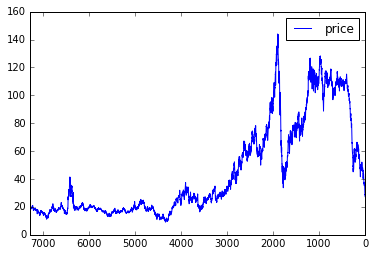

In [4]:
crude_df[['date', 'price']].plot()


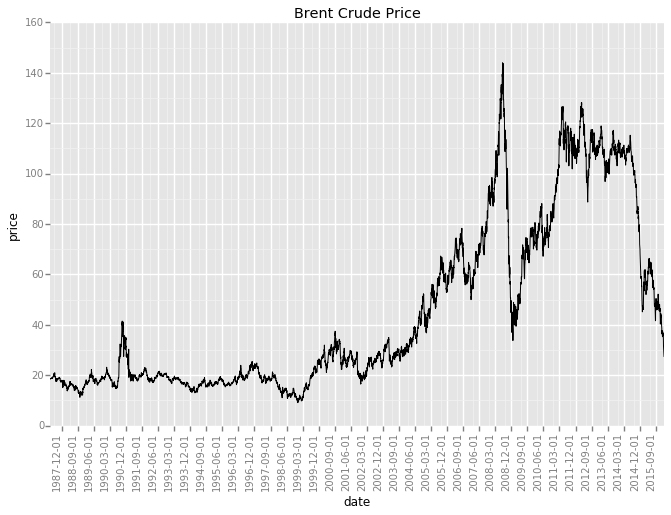

<ggplot: (297029425)>

In [48]:
g = ggplot.ggplot(crude_df, ggplot.aes('date', 'price')) + ggplot.geom_line()  
g = g + ggplot.scale_x_date(labels = ggplot.date_format("%Y-%m-%d"), breaks=ggplot.date_breaks('9 months'))
g = g + ggplot.theme(axis_text_x = ggplot.element_text(angle = 90)) + ggplot.ggtitle("Brent Crude Price")
g

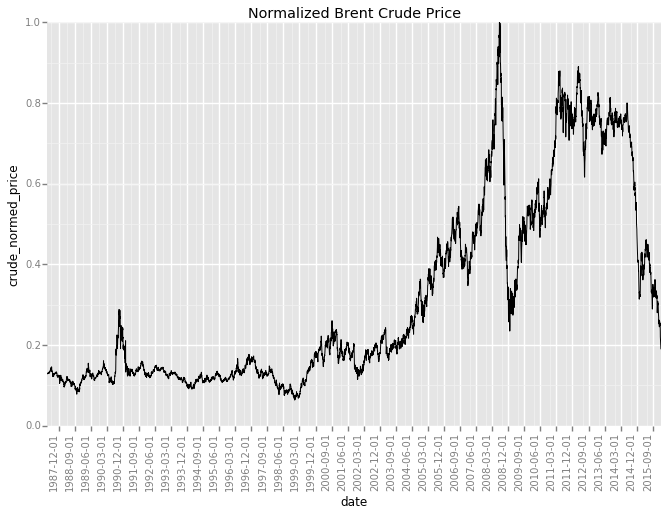

<ggplot: (297251469)>

In [49]:
g = ggplot.ggplot(crude_df, ggplot.aes('date', 'crude_normed_price')) + ggplot.geom_line()  
g = g + ggplot.scale_x_date(labels = ggplot.date_format("%Y-%m-%d"), breaks=ggplot.date_breaks('9 months'))
g = g + ggplot.theme(axis_text_x = ggplot.element_text(angle = 90)) + ggplot.ggtitle("Normalized Brent Crude Price")
g

In [7]:
# Fetch kenya pump prices from the ERC
# Source: http://www.erc.go.ke/index.php?option=com_content&view=article&id=162&Itemid=666

erc_url = 'http://www.erc.go.ke/index.php?option=com_content&view=article&id=162&Itemid=666'

def get_available_erc_data_dates(erc_data_page_url):
    '''
    The data published by ERC is accessed using an index for a 'month' date_range.
    We need to prefetch all the available date indices.
    '''
    available_dates = []
    resp = requests.get(erc_data_page_url)
    erc_content = BeautifulSoup(resp.content)
    erc_data_table = erc_content.find(name='div', attrs={'class':"item-page"}).table
    for option in erc_data_table.find('select').findAll():
        available_dates.append({
                'date_range': option.attrs.get('value'), 
                'value': option.text,
                'datetime':dateutil.parser.parse(option.text.split('-')[0]) 
            }
        )
    return available_dates

def fetch_erc_data_for_date_range(erc_data_url, date_range, date_range_datetime):
    '''
    ERC has a form that you post to a custom date range that spans a month's worth of time
    We need to parse the html content and extract the data in html tables
    '''
    resp = requests.post(erc_data_url, data=dict(date_range=date_range, submitP='Search'))
    erc_content = BeautifulSoup(resp.content)
    erc_data_table = erc_content.find(name='div', attrs={'class':"item-page"}).table
    data_rows = erc_data_table.find('table').findAll('tr')
    fields = [header.text for header  in data_rows[0].findAll('th')]

    rows = []
    for row in data_rows[1:]:
        row_dict = dict(zip(fields, [column.text for column in row.findAll('td')]))
        row_dict['date'] = date_range_datetime
        rows.append(row_dict)

    return rows

def get_erc_data_as_dict():
    rows_of_dicts = []
    for available_date in get_available_erc_data_dates(erc_url):
        print "Fetching data for %s" % available_date.get('value')
        rows = fetch_erc_data_for_date_range(erc_url, available_date.get('date_range'),  available_date.get('datetime'))
        rows_of_dicts.extend(rows)
    return rows_of_dicts

def get_erc_data_as_df():
    return pandas.DataFrame(get_erc_data_as_dict())


In [8]:
erc_prices_df = get_erc_data_as_df()

Fetching data for Jan 15th, 2016 - Feb 14th, 2016 
Fetching data for Dec 15th, 2015 - Jan 14th, 2016 
Fetching data for Nov 15th, 2015 - Dec 14th, 2015 
Fetching data for Oct 15th, 2015 - Nov 14th, 2015 
Fetching data for Sep 15th, 2015 - Oct 14th, 2015 
Fetching data for Aug 15th, 2015 - Sep 14th, 2015 
Fetching data for Jul 15th, 2015 - Aug 14th, 2015 
Fetching data for Jun 15th, 2015 - Jul 14th, 2015 
Fetching data for May 15th, 2015 - Jun 14th, 2015 
Fetching data for Apr 15th, 2015 - May 14th, 2015 
Fetching data for Mar 15th, 2015 - Apr 14th, 2015 
Fetching data for Feb 16th, 2015 - Mar 15th, 2015 
Fetching data for Jan 15th, 2015 - Feb 14th, 2015 
Fetching data for Dec 15th, 2014 - Jan 14th, 2015 
Fetching data for Nov 15th, 2014 - Dec 14th, 2014 
Fetching data for Oct 15th, 2014 - Nov 14th, 2014 
Fetching data for Sep 15th, 2014 - Oct 15th, 2014 
Fetching data for Aug 15th, 2014 - Sep 14th, 2014 
Fetching data for Jul 15th, 2014 - Aug 14th, 2014 
Fetching data for Jun 15th, 201

/Users/mickeymouse/venvs/default/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [32]:
# Cached at: http://pastebin.com/Z8vqDCgr
# Loadable data: http://pastebin.com/raw/Z8vqDCgr
# data_url =  PastebinAPI().paste(pastebin_api_key, erc_prices_df.to_csv(), paste_name="ERC Kenya Petroleum prices", paste_format="text")
# print data_url

http://pastebin.com/Z8vqDCgr


In [9]:
erc_prices_df['super_normed_price'] =  erc_prices_df.Super.astype(float) / max(erc_prices_df.Super.astype(float))
zero_idx = erc_prices_df.super_normed_price != 0
erc_prices_df_clean = erc_prices_df[zero_idx]
erc_prices_df_clean.head()

,Diesel,Kerosene,Regular,Super,Town,date,super_normed_price
0,79.55,48.93,108.03,91.31,Bomet,2016-01-15,0.700069
1,79.14,48.32,107.58,90.9,Bondo,2016-01-15,0.696926
2,79.55,48.8,108.01,91.3,Bungoma,2016-01-15,0.699992
3,80.14,49.32,108.48,91.9,Busia,2016-01-15,0.704593
4,78.44,47.87,107.34,90.38,Chuka,2016-01-15,0.692939


In [10]:
erc_prices_nairobi_df = erc_prices_df_clean[erc_prices_df.Town=='Nairobi']
erc_prices_nairobi_df.head()

/Users/mickeymouse/venvs/default/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,Diesel,Kerosene,Regular,Super,Town,date,super_normed_price
50,76.7,46.13,105.76,88.64,Nairobi,2016-01-15,0.679598
120,78.51,53.27,105.76,90.06,Nairobi,2015-12-15,0.690485
190,79.66,54.81,105.76,90.46,Nairobi,2015-11-15,0.693552
260,82.43,56.04,105.76,93.29,Nairobi,2015-10-15,0.715250
330,79.99,52.55,0,102.65,Nairobi,2015-09-15,0.787012


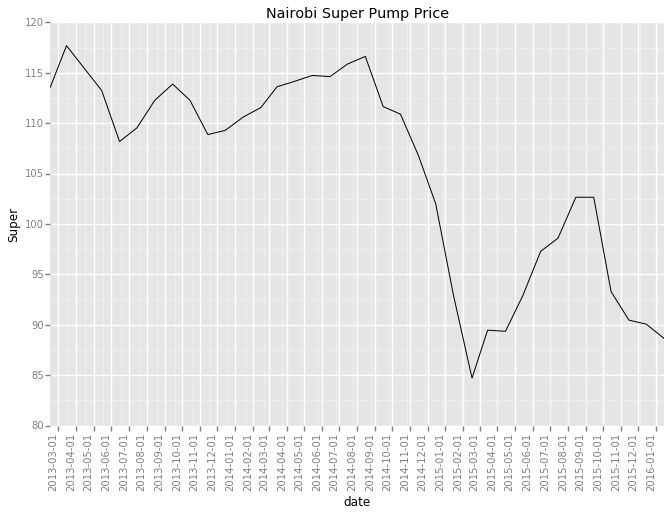

<ggplot: (296571333)>

In [46]:
g = ggplot.ggplot(erc_prices_nairobi_df, ggplot.aes('date', 'Super')) + ggplot.geom_line()  
g = g + ggplot.scale_x_date(labels = ggplot.date_format("%Y-%m-%d"), breaks=ggplot.date_breaks('1 months'))
g = g + ggplot.theme(axis_text_x = ggplot.element_text(angle = 90)) + ggplot.ggtitle("Nairobi Super Pump Price")
g

In [35]:
min_erc_date = min(erc_prices_nairobi_df.date)
erc_crude_date_intersection_df = crude_df[crude_df.date > min_erc_date]

# Renorm the data
erc_crude_date_intersection_df['crude_normed_price'] =  erc_crude_date_intersection_df.price / max(erc_crude_date_intersection_df.price)
# Renorm this field for the subsetted dataframe
erc_prices_nairobi_df['super_normed_price'] =  erc_prices_nairobi_df.super_normed_price / max(erc_prices_nairobi_df.super_normed_price)



/Users/mickeymouse/venvs/default/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mickeymouse/venvs/default/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


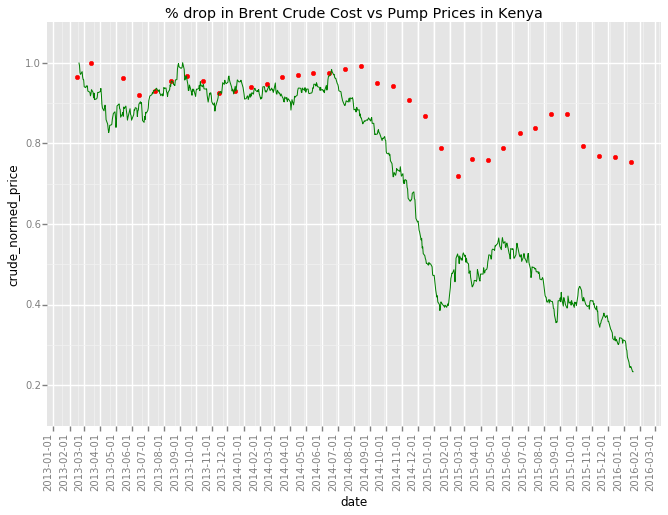

<ggplot: (295938557)>

In [44]:
# So let's compare the normalised crude oil purchase price to the normalised Nairobi Pump price
# Ideally, these graphs should be identical!
# If the oligopolies argue that they are a few months late in tracking the global crude prices,
#  we should see the red dot graph slightly right shifted over the blue one.
g = ggplot.ggplot(erc_crude_date_intersection_df, ggplot.aes('date', 'crude_normed_price')) + ggplot.geom_line(colour="green") 
g = g + ggplot.geom_point(ggplot.aes(x='date', y='super_normed_price'), data=erc_prices_nairobi_df,  color="red")
g = g + ggplot.scale_x_date(labels = ggplot.date_format("%Y-%m-%d"), breaks=ggplot.date_breaks('1 months'))
g = g + ggplot.theme(axis_text_x = ggplot.element_text(angle = 90)) + ggplot.ggtitle("% drop in Brent Crude Cost vs Pump Prices in Kenya")
g

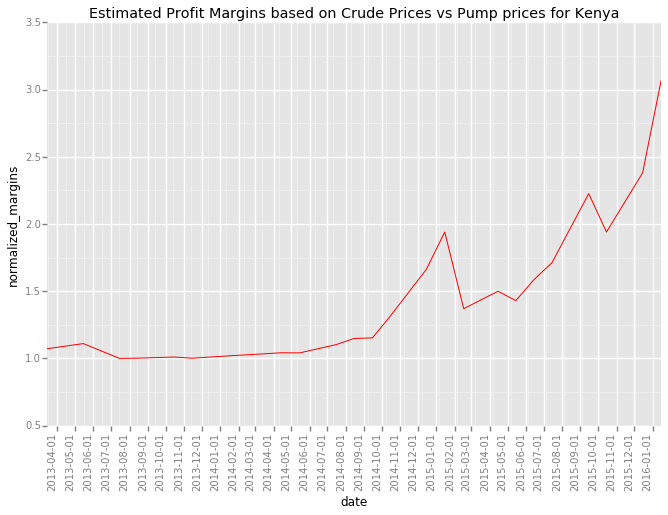

<ggplot: (295937509)>

In [43]:
# Let's plot the difference between the normalised crude oil price and the pump price,
# If profits margins are the same, we should see a straight line here, otherwise,
#  - if the graph goes up with time, we are getting shafted.
#  - if the graph goes down with time, we are getting a good deal.

# We have to renormalize again because merging may drop some rows.
merged_df = pandas.merge(erc_crude_date_intersection_df, erc_prices_nairobi_df, how='inner', on=['date', 'date'])
merged_df['normalized_margins'] = merged_df.super_normed_price / merged_df.crude_normed_price
merged_df['super_normed_price'] =  merged_df.Super.astype(float) / max(merged_df.Super.astype(float))
merged_df['crude_normed_price'] =  merged_df.price / max(merged_df.price)



g = ggplot.ggplot(merged_df, ggplot.aes('date', 'normalized_margins')) + ggplot.geom_line(colour="red") 
g = g + ggplot.scale_x_date(labels = ggplot.date_format("%Y-%m-%d"), breaks=ggplot.date_breaks('1 months'))
g = g + ggplot.theme(axis_text_x = ggplot.element_text(angle = 90)) + ggplot.ggtitle("Estimated Profit Margins based on Crude Prices vs Pump prices for Kenya")
g

In [15]:
# As you can see from the graph above, we are thoroughly getting shafted.
# 1. 'Super' petrol margins have gone up by >200% over the past 2 years.
# 2. It's rather obvious that petrol companies in Kenya are not tracking global prices. 
#   If anything, they are keeping prices artificially high and pocketing the change
# In other words, Petrol companies are making 2-3 times the profit they made in 2013

In [16]:
# So the arguement might be that the Kenyan currency has lost value.
# We can work around this by converting the KES pump price to the equivalent USD value
# at the time by using historical data from CBK.


In [17]:
# Let's fetch Central bank of Kenya Forex data
# Source https://www.centralbank.go.ke/index.php/interest-rates/commercial-banks-weighted-av

cbk_data_url = 'https://www.centralbank.go.ke/index.php/interest-rates/commercial-banks-weighted-av' 


def fetch_cbk_data_as_dicts(cbk_data_url):
    resp = requests.post(cbk_data_url, 
            data=dict(
                # Start date
                date=22, month=1, year=2007, 
                # End date
                tdate=22, tmonth=1, tyear=2016, 
                currency='US DOLLAR', searchForex='Search'),
            # CBK has a braindead policy of blocking non-ui browser agents
            headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.11; rv:43.0) Gecko/20100101 Firefox/43.0'})

    cbk_content = BeautifulSoup(resp.content)
    cbk_data_table_header = cbk_content.find(name='div', attrs={'id':"interbank"}).table.find('tr', attrs={'class': 'tr_heading'})
    headers = [td.text for td in cbk_data_table_header.findAll('td')]
    rows_of_dicts = []

    for table_row in cbk_data_table_header.fetchNextSiblings():
        row = [td.text for td in table_row.findAll('td')]
        rows_of_dicts.append(dict(zip(headers, row)))
    return rows_of_dicts

def fetch_cbk_data_as_df(cbk_data_url):
    return pandas.DataFrame(fetch_cbk_data_as_dicts(cbk_data_url))



In [18]:
cbk_usd_df = fetch_cbk_data_as_df(cbk_data_url)
cbk_usd_df['date'] = cbk_usd_df.Date.map(lambda x: dateutil.parser.parse(x, dayfirst=True))
cbk_usd_df = cbk_usd_df.sort(['date'], ascending=True)
cbk_usd_df.head(15)

/Users/mickeymouse/venvs/default/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,Buy,Currency,Date,Mean,Sell,date
76,69.8256,US DOLLAR,22-01-2007,69.8978,69.9700,2007-01-22
77,70.0011,US DOLLAR,23-01-2007,70.0733,70.1456,2007-01-23
78,70.0711,US DOLLAR,24-01-2007,70.1433,70.2156,2007-01-24
79,70.2300,US DOLLAR,25-01-2007,70.2994,70.3689,2007-01-25
80,70.4411,US DOLLAR,26-01-2007,70.5056,70.5700,2007-01-26
81,70.5533,US DOLLAR,29-01-2007,70.6256,70.6978,2007-01-29
82,70.4956,US DOLLAR,30-01-2007,70.5567,70.6178,2007-01-30
83,70.4756,US DOLLAR,31-01-2007,70.5367,70.5978,2007-01-31
84,70.3167,US DOLLAR,01-02-2007,70.3722,70.4278,2007-02-01
85,70.2000,US DOLLAR,02-02-2007,70.2722,70.3444,2007-02-02


In [39]:
# Cached here: http://pastebin.com/345FHtWH
# data_url =  PastebinAPI().paste(pastebin_api_key, cbk_usd_df.to_csv(), paste_name="CBK Kenya USD Forex rates", paste_format="text")
# print data_url

http://pastebin.com/345FHtWH


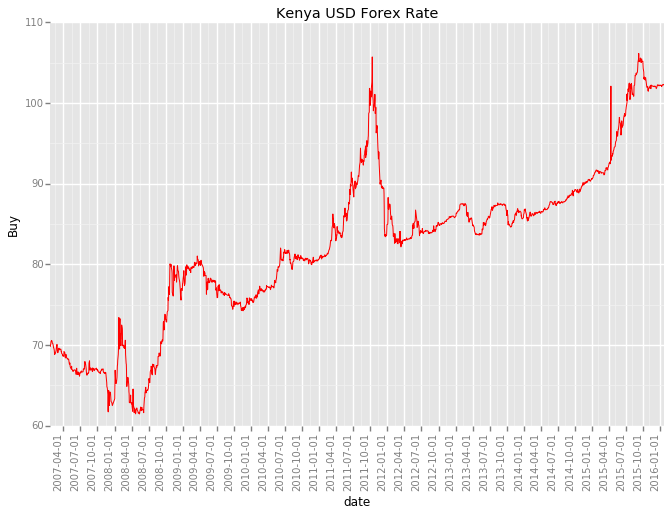

<ggplot: (295776609)>

In [42]:
# Let's see what the USD / KES rate looks like
g = ggplot.ggplot(cbk_usd_df, ggplot.aes('date', 'Buy')) + ggplot.geom_line(colour="red") 
g = g + ggplot.scale_x_date(labels = ggplot.date_format("%Y-%m-%d"), breaks=ggplot.date_breaks('3 month'))
g = g + ggplot.theme(axis_text_x = ggplot.element_text(angle = 90)) + ggplot.ggtitle("Kenya USD Forex Rate")
g

In [86]:
merged_df_with_usd = pandas.merge(merged_df, cbk_usd_df, how='inner', on=['date', 'date'])
# Convert the super price to USD
merged_df_with_usd['super_as_usd'] = merged_df_with_usd.Super.astype(float) / merged_df_with_usd.Mean.astype(float)

# Normalise the USD super price
merged_df_with_usd['normalised_super_as_usd'] = merged_df_with_usd.super_as_usd / max(merged_df_with_usd.super_as_usd) 


# And the USD Margins
merged_df_with_usd['normalized_margins_usd'] = merged_df_with_usd.normalised_super_as_usd / merged_df_with_usd.crude_normed_price


merged_df_with_usd.head()

,day,price,date,crude_normed_price,Diesel,Kerosene,Regular,Super,Town,super_normed_price,normalized_margins,Buy,Currency,Date,Mean,Sell,super_as_usd,normalised_super_as_usd,normalized_margins_usd
0,03/15/2013,109.32,2013-03-15,0.979745,107.37,88.54,105.76,117.69,Nairobi,1.000000,1.071625,85.5389,US DOLLAR,15-03-2013,85.6361,85.7333,1.374304,1.000000,1.020673
1,05/15/2013,101.57,2013-05-15,0.910289,101.06,79.46,105.76,113.24,Nairobi,0.962189,1.109781,83.7222,US DOLLAR,15-05-2013,83.8069,83.8917,1.351201,0.983190,1.080086
2,07/15/2013,109.05,2013-07-15,0.977326,102.86,79.49,105.76,109.52,Nairobi,0.930580,0.999702,87.1344,US DOLLAR,15-07-2013,87.2364,87.3383,1.255439,0.913509,0.934703
3,08/15/2013,111.58,2013-08-15,1.000000,104.44,83.93,105.76,112.26,Nairobi,0.953862,1.001478,87.5044,US DOLLAR,15-08-2013,87.5906,87.6767,1.281644,0.932577,0.932577
4,10/15/2013,110.67,2013-10-15,0.991844,104.47,85.01,105.76,112.27,Nairobi,0.953947,1.009803,84.8944,US DOLLAR,15-10-2013,84.9944,85.0944,1.320911,0.961149,0.969052


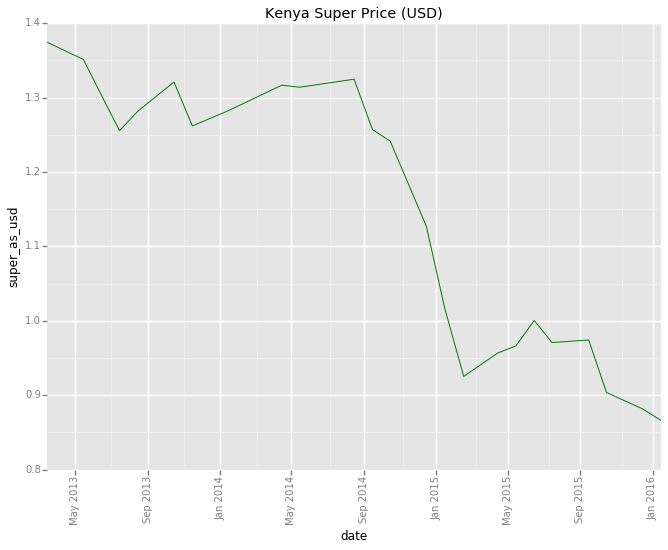

<ggplot: (295167589)>

In [41]:
# How does the USD price of the pump prices in Kenya look like?
g = ggplot.ggplot(merged_df_with_usd, ggplot.aes('date', 'super_as_usd')) + ggplot.geom_line(colour="green") 
g = g + ggplot.theme(axis_text_x = ggplot.element_text(angle = 90)) + ggplot.ggtitle("Kenya Super Price (USD)")
g

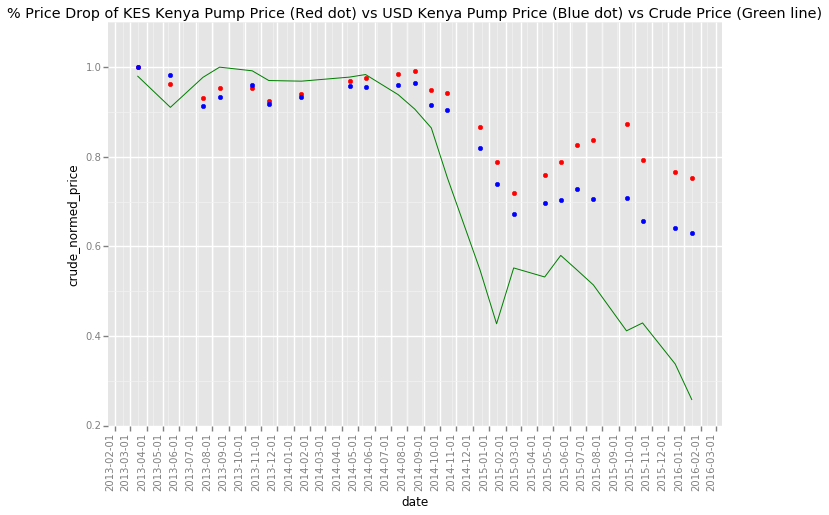

<ggplot: (297819617)>

In [51]:
# So let's compare how all three normalised prices.
# If there's a huge departured between the normalised_USD pump price and the KES pump price in the graph
# below, we can the ascribe the margin deltas to the devaluation of KES. 
# If there change between the two graphs is marginal, then we can infer that the devaluation arguement is moot
g = ggplot.ggplot(merged_df_with_usd, ggplot.aes('date', 'crude_normed_price')) + ggplot.geom_line(colour="green") 
g = g + ggplot.geom_point(ggplot.aes(x='date', y='super_normed_price'), data=merged_df_with_usd,  color="red")
g = g + ggplot.scale_x_date(labels = ggplot.date_format("%Y-%m-%d"), breaks=ggplot.date_breaks('1 months'))
g = g + ggplot.geom_point(ggplot.aes(x='date', y='normalised_super_as_usd'), data=merged_df_with_usd,  color="blue")
g = g + ggplot.theme(axis_text_x = ggplot.element_text(angle = 90)) + ggplot.ggtitle("% Price Drop of KES Kenya Pump Price (Red dot) vs USD Kenya Pump Price (Blue dot) vs Crude Price (Green line)")
g

In [62]:
# US Gas prices. Source: https://ycharts.com/indicators/gas_price
us_gas_price_url = 'https://ycharts.com/charts/fund_data/json?securities=type%3Aindicator%2Cid%3AI%3AUSRGP%2Cinclude%3Atrue%2C%2C&calcs=id%3Aprice%2Cinclude%3Atrue%2C%2C&correlations=&format=real&recessions=false&zoom=5&startDate=&endDate=&chartView=&splitType=&scaleType=&note=&title=&source=&units=&quoteLegend=&partner=&quotes=&legendOnChart=&securitylistSecurityId=&clientGroupLogoUrl=&maxPoints=650&' 

def get_us_gas_prices(us_gas_price_url):
    resp = requests.get(us_gas_price_url)
    us_gas_prices_json = resp.json()
    return [{'date': datetime.fromtimestamp(row[0] / 1000), 'gallon_price': row[1]} 
                for row in us_gas_prices_json['chart_data'][0][0]['raw_data']]
us_gas_prices = get_us_gas_prices(us_gas_price_url)
us_gas_prices_df = pandas.DataFrame(us_gas_prices)

In [52]:
# Cached here: http://pastebin.com/Jda1iAAT
# data_url =  PastebinAPI().paste(pastebin_api_key, us_gas_prices_df.to_csv(), paste_name="US Gas Cost from ycharts", paste_format="text")
# print data_url

http://pastebin.com/Jda1iAAT


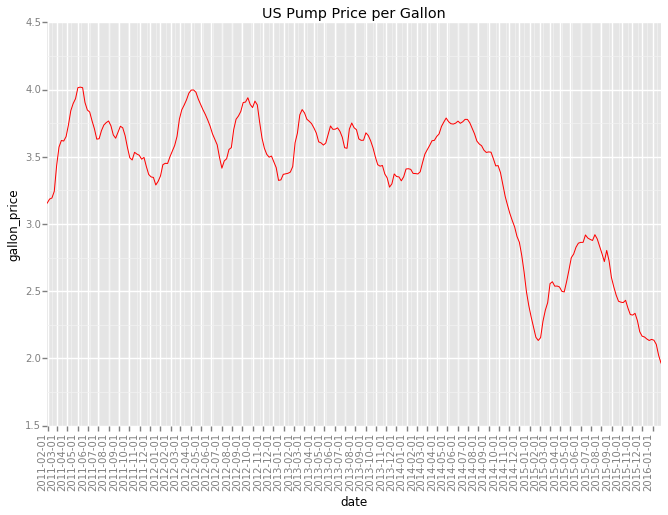

<ggplot: (298367705)>

In [64]:
g = ggplot.ggplot(us_gas_prices_df, ggplot.aes('date', 'gallon_price')) + ggplot.geom_line(colour="red")
g = g + ggplot.scale_x_date(labels = ggplot.date_format("%Y-%m-%d"), breaks=ggplot.date_breaks('1 months'))
g = g + ggplot.theme(axis_text_x = ggplot.element_text(angle = 90)) + ggplot.ggtitle("US Pump Price per Gallon")
g

/Users/mickeymouse/venvs/default/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


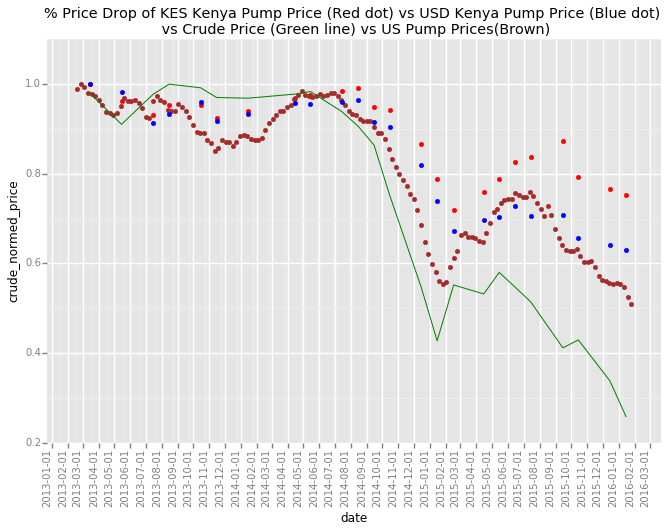

<ggplot: (298598673)>

In [77]:
# Normalized and compared to KE & crude prices 
min_erc_date = min(erc_prices_nairobi_df.date)
erc_us_gas_prices_df_intersection_df = us_gas_prices_df[us_gas_prices_df.date > min_erc_date.date()]

erc_us_gas_prices_df_intersection_df['normalized_gallon_price'] = erc_us_gas_prices_df_intersection_df.gallon_price / max(erc_us_gas_prices_df_intersection_df.gallon_price)



g = ggplot.ggplot(merged_df_with_usd, ggplot.aes('date', 'crude_normed_price')) + ggplot.geom_line(colour="green") 
g = g + ggplot.geom_point(ggplot.aes(x='date', y='super_normed_price'), data=merged_df_with_usd,  color="red")
g = g + ggplot.geom_point(ggplot.aes(x='date', y='normalized_gallon_price'), data=erc_us_gas_prices_df_intersection_df,  color="brown")
g = g + ggplot.scale_x_date(labels = ggplot.date_format("%Y-%m-%d"), breaks=ggplot.date_breaks('1 months'))
g = g + ggplot.geom_point(ggplot.aes(x='date', y='normalised_super_as_usd'), data=merged_df_with_usd,  color="blue")
g = g + ggplot.theme(axis_text_x = ggplot.element_text(angle = 90)) + ggplot.ggtitle("% Price Drop of KES Kenya Pump Price (Red dot) vs USD Kenya Pump Price (Blue dot) \n vs Crude Price (Green line) vs US Pump Prices(Brown)")
g

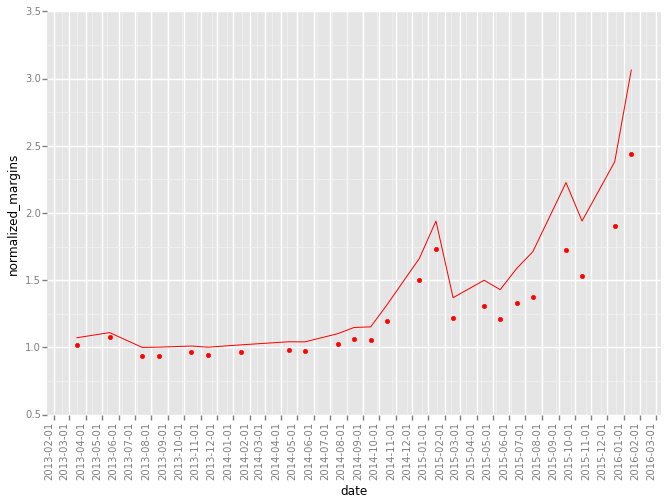

<ggplot: (300572801)>

In [87]:
# Granted that the KES has devalued in th recent past, there devalution has changed the USD pump price by at most 10%
# If we plot the margins, we should still see that the Oilers are making significantly more in profits

g = ggplot.ggplot(merged_df_with_usd, ggplot.aes('date', 'normalized_margins')) + ggplot.geom_line(colour="red")
g = g + ggplot.geom_point(ggplot.aes(x='date', y='normalized_margins_usd'), data=merged_df_with_usd,  color="red")
g = g + ggplot.scale_x_date(labels = ggplot.date_format("%Y-%m-%d"), breaks=ggplot.date_breaks('1 months'))
g = g + ggplot.theme(axis_text_x = ggplot.element_text(angle = 90))
g

In [96]:
# The points above still show that exchange rate impact is minimal to profit margins.
# If the oilers are to get the same profits as 2014-10-01 (~1.4 over the Brent crude as opposed to the current ~3.0),
# then the pump prices should be current price * 1.4 / 3.0
#In other words, we should be paying
todays_row = merged_df_with_usd.tail(1)
todays_row
fair_price = todays_row['crude_normed_price'].astype('float') * max(merged_df_with_usd['super_as_usd']).astype('float') * todays_row['Mean'].astype('float') 
print "Fair pump price (KES): ",fair_price.values[0]
# Yep the figure is 36.30 Shillings.

# As USD
fair_price_usd = fair_price.values[0] / todays_row['Mean'].astype(float)
print "Fair pump price (USD): ", fair_price_usd.values[0]

# According to this: http://www.thenakedscientists.com/forum/index.php?topic=42516.0
# 1 barrel of oil ~ 42 us gallons
barrel_in_liters = 3.79 * 42

# Total cost of raw crude per liter in KES 
raw_crude_cost_per_liter = todays_row['Mean'].astype(float) * todays_row['price'] / barrel_in_liters
print "Raw crude cost per liter (KES): ", raw_crude_cost_per_liter.values[0]

print "Cost of distillation + profit as a function of the raw product per liter (Unfair price):",  (todays_row['Super'].astype('float') - raw_crude_cost_per_liter.values[0]).values[0]
print "Cost of distillation + profit as a function of the raw product per liter (Fair price):",  (fair_price - raw_crude_cost_per_liter.values[0]).values[0] 
print "Oilers extra profit per liter (over and above 2013 profit margins): ", (todays_row['Super'].astype('float') - fair_price).values[0]

Fair pump price (KES):  36.3067410612
Fair pump price (USD):  0.354722562333
Raw crude cost per liter (KES):  18.5183565775
Cost of distillation + profit as a function of the raw product per liter (Unfair price): 70.1216434225
Cost of distillation + profit as a function of the raw product per liter (Fair price): 17.7883844837
Oilers extra profit per liter (over and above 2013 profit margins):  52.3332589388


In [97]:
# Summary
# Sources: https://ycharts.com/indicators/gas_price
# 1. US Gas (Petrol) prices were 3.764 in Mar 18 2013, 
# 2. US Gas prices are now 2.02 in Jan 18 2016
# 3. Total percentage change: 46% drop in price: -46.3336875664187
print "Drop in US pump price:", (2.02 - 3.764) * 100 / 3.764

# 4. KE GAS prices in Mar 15 2013 was: 117.69
# 5. KE Gas Prices are now: 88.64
# 6. Total percentage change: 24% drop in price.
print "Drop in KE pump price:", (88.64 - 117.69) * 100 / 117.69

# Let's take care of devaluation
# 4. KE USD GAS prices in Mar 15 2013 was: 1.374304
# 5. KE USD Gas Prices are now: 0.866027
# 6. Total percentage change: 24% drop in price.
print "Drop in KE (USD) pump price:", (0.866027 - 1.374304) * 100 / 1.374304

# If we were to pay the US rate, this is the pump price that we should pay (inclusive of currency devaluation):
print "Pump price if we were to drop our prices to the same level as the US...: ", 46.3336875664/ 100 * 1.374304 * 102.3525
#(US % Drop) * Price in Mar 2013 as USD * Current USD/KES Forex rate

Drop in US pump price: -46.3336875664
Drop in KE pump price: -24.683490526
Drop in KE (USD) pump price: -36.9843207907
Pump price if we were to drop our prices to the same level as the US...:  65.1745635173
